In [1]:
'''
Code to read NIFTI files

'''

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from mpl_toolkits import mplot3d #for 3d plots

from copy import copy, deepcopy  #to copy matrices
import numpy as np
import os
#import pydicom  --installed in colab bia pip
from PIL import Image #for RGB manipulation

import matplotlib.animation as animation #just for animating a plot

#generic toolset for transformations
import scipy.misc
from scipy import ndimage
import scipy.io as sio
from scipy import signal  #for convolution filtering
import cv2 as cv2         #for convolution filtering
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 
!pip3 install -q SimpleITK
!pip3 install -q medpy
!pip3 install nibabel          #NIFTI library support
!pip3 install -q celluloid     #animation extra library

import SimpleITK as sitk  #for reading mha files
from medpy.io import load #mha files
import pydicom #to read dicom files
import nibabel as nib         #pull in library
from celluloid import Camera  #for an alternative animation method



#
# Load data from google drive
#

drive.mount('/content/gdrive')

'''
GET FILE LISTING----------------------------------------------------------------
'''
def get_dirs(top_dir = '/content/gdrive/My Drive/BIOENG223A_FALL_2019/data/'):
    import os

    dir_list = os.scandir(top_dir)
    directories=[]
    file_list = {}
    for ii in dir_list:
        file_list[ii.name]=[]
        directories.append(ii.name)
        #get file listings for each directory found
        files = os.scandir(os.path.join(top_dir,ii.name))
        for jj in files:
            file_list[ii.name].append(jj.name)


    
    return directories, file_list


'''
################################################################################
GET FILES FROM DATA DIRECTORIES
################################################################################
'''
def get_nii_files(dir_list, file_list, text,extension):
    import os

    folder_file={}
    for ii in dir_list:
        #print(ii)
        fulldir = os.path.join(main_directory,ii)
        for jj in file_list[ii]:
            if text in jj: #found a matching file
                #print(jj)
                if extension in jj:
                    folder_file[ii] = jj
                    print('found proper ',text, jj)


    print(folder_file)
    return folder_file







'''
################################################################################
Create the binary NIFTI file to be updated later
-- needs sizes for new data, original NIFTI header
################################################################################
'''
def create_binary_nifti(numrows,numcols, depth):

    import numpy as np

    binary_data=np.zeros((numrows, numcols, depth))

    print('Created 3D cube with sizes r x c x d: ', numrows, numcols, depth)

    return binary_data





'''
REPLACE NAN DATA----------------------------------------------------------------
'''
def replace_nan(data, lowval=-1600):
    #a=np.isnan(data)
    #lowval = -1600
    new_data = data #only a slice should be sent in here
    new_data[np.isnan(new_data)]= lowval

    a = np.isnan(new_data)
    #print('sample value after nan replace (0,0) : ',new_data[0,0])
    sdata = new_data #new_data[215:220,145:155,140]
    row,col = np.shape(sdata)
    #print('nan replace shape is ', row,col)

    return sdata

'''
Celluloid animation package
'''
def cell_animate(image_dir, 
                 base_filename, 
                 stack,
                 slice_column =2,
                 cmapin='bone',
                 cbar = 1):
    fig = plt.figure()
    camera = Camera(fig)

    #fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize=(5, 5),squeeze=False)
    #camera = Camera(fig)

    dir_name = image_dir #"/home/kgonzalez/IMAGES"
    #base_filename = "figure"
    filename_suffix = ".png"
    x,y,num_frames = np.shape(stack) 

    vidfile = os.path.join(dir_name,'animatedct.gif');
    for ii in range(0,num_frames):
        
        plt.imshow(stack[:,:,ii],cmap=cmapin)
        plt.title('CT Skull Image')
        #if (cbar == 1):
        #    plt.colorbar()
        #im0 = axes[0].imshow(stack[:,:,ii],cmap=cmapin);
        #use fraction and pad to shrink colorbar to fit image
        #fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
        #name = os.path.join(dir_name, base_filename + str(ii).zfill(5)  + filename_suffix)
        #print('name is: ',name)
        
        #plt.savefig(name) # save as png

        camera.snap()
    animation = camera.animate()
    animation.save(vidfile, writer = 'imagemagick')


    return 0

'''
ANIMATE IMAGES------------------------------------------------------------------
'''
def animate_image(image_dir, base_filename, stack):
    plt.close()
    plt.rcParams["animation.html"] = "jshtml"

    #plt.figure()
    #plt.imshow(stack[:,:,300])
    fig=plt.figure()
    #plt.imshow(stack[:,:,255])
    ims = []
    dir_name = image_dir #"/home/kgonzalez/IMAGES"
    #base_filename = "figure"
    filename_suffix = ".png"
    x,y,num_frames = np.shape(stack) 
    print('number of frames to animate is ',num_frames)
    for ii in range(0,num_frames):
        im = plt.imshow(stack[:,:,ii], animated=True)
        ims.append([im])
        plt.imshow(stack[:,:,ii],cmap='gray')
        plt.title('CT Skull Image')
        name = os.path.join(dir_name, base_filename + str(ii).zfill(5)  + filename_suffix)
        #print('name is: ',name)
        
        plt.savefig(name) # save as png
    print('done animating images')
    plt.show()
    ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
        repeat_delay=500)
    #plt.show()
    mp4name = os.path.join(dir_name, 'dyn.mp4')
    ani.save(mp4name)
    print('done with animation mp4')
    return 0




def read_NIFTI():
    print("test")


'''
FIND METAL COMPONENTS-----------------------------------------------------------
'''
def find_metal_mass(section,
                    scaled_hull_dict,
                    slicenum,
                    dx,
                    dy,
                    mx,
                    my,
                    metal_value,
                    depth,
                    lower_val=0.85,
                    upper_val=1.1):
    #upper_val = 1.15 #110% of incoming value
    #lower_val = 0.85
    row1,col1 = np.shape(section) #section.shape() #should be just one slice
    #output_coordinates = set()

    output_coordinates = []

    #print('in find_metal_mass, row and col are ',row1, col1)
    for row in range(0,row1):
        for col in range(0,col1):
            #find a voxel that is surrounded on all 4 sides by the 
            #metal_value voxels depth wide
            pixel_x = col
            pixel_y = row

            if ((row - depth) >= 0):
                if ((col - depth) >= 0):
                    #if we're not on the boundaries, check to see if we have 
                    #voxel values around us within 10% of the metal_value

                    #if pixel - col depth : pixel + col depth AND
                    #if pixel - row depth: pixel + row depth are all within the
                    #range for metal, keep this pixel as a possible match

                    avg_cols = np.average(section[row,col-depth:col+depth])
                    avg_rows = np.average(section[row-depth:row+depth,col])
                    #print('row,col: avgc, avgr ', pixel_y, pixel_x,
                    #      avg_cols, avg_rows)
                    if ( (avg_cols >= (lower_val*metal_value) and (avg_cols <= (upper_val*metal_value))) \
                        and \
                        ((avg_rows >= (lower_val*metal_value)) and (avg_cols <= (upper_val*metal_value))) \
                        ):

                        #
                        # Check to see if this point is also within the hull
                        #
                        valid_point = 0
                        valid_point = is_point_in_hull(scaled_hull_dict,
                                                       slicenum,
                                                       mx,
                                                       my,
                                                       dx,
                                                       dy,
                                                       pixel_x,
                                                       pixel_y)
                        
                        #valid_point =1 #DEBUG ONLY!!!

                        #print('found one pixel')
                        #append a list of values per pixel instead of adding to 
                        #a large list of xy
                        if (valid_point == 1):

                            coordinate=[]
                            coordinate.append([pixel_y,pixel_x]) 
                            output_coordinates.append([pixel_y,pixel_x]) #coordinate)
                        #output_coordinates.append(pixel_y)
                        #output_coordinates.append(pixel_x)
                        
                    #sum_value = np.sum(section[row-depth:row+depth,col-depth:col+depth])
                    #print('sum_value ',sum_value)
    return output_coordinates



def find_dbs_length(section, metal_value, depth,lower_val=0.7, upper_val=1.15):
    #upper_val = 1.15 #110% of incoming value
    #lower_val = 0.7
    row1,col1 = np.shape(section) #section.shape() #should be just one slice
    
    output_coordinates = set()

    #print('in find_metal_mass, row and col are ',row1, col1)
    for row in range(0,row1):
        for col in range(0,col1):
            #find a voxel that is diagonally or straight across

            pixel_x = col
            pixel_y = row
            #for each pixel, make sure we can't go out of bounds

            #if ((row - depth) >= 0):
            #    if ( (avg_cols >= (lower_val*metal_value) and (avg_cols <= (upper_val*metal_value))) \
            #        and \
            #        ((avg_rows >= (lower_val*metal_value)) and (avg_cols <= (upper_val*metal_value))) \
            #        ):
            #            #print('found one pixel')
            #        output_coordinates.add((pixel_y, pixel_x))
            #        #sum_value = np.sum(section[row-depth:row+depth,col-depth:col+depth])
            #        #print('sum_value ',sum_value)           

    return 0



'''
THRESHOLD METAL SPOTS
--Returns all pixels throughout a slice direction that is close to a metallic
return value
'''
def threshold_pixels3D(volume_data, #push in whole volume
                       metal_value, #typical metal value for this dataset
                       depth, 
                       lower_val=0.7, 
                       upper_val=1.15):

    x,y, numslices = np.shape(volume_data)

    

    return 0





def threshold_pixels2D():

    return 0





def plot_metal_points_2D(slice_data):
    plt.imshow(slice_data[:,:,ii],cmap='gray',vmin=-1600, vmax=3300)
    plt.xlabel('X vox')
    plt.ylabel('Y vox')
    tname = 'Image Slice #' + np.str(ii)

    plt.show()

    metal_xy = metal_points[ii]
    for ii in metal_xy:
        r = ii[0]
        c = ii[1]
        #print('row, col is ', r, c)
        circle1 = plt.Circle((c,r), 3,color='r', fill=False)
        #ax.set_aspect(1)
        ax.add_patch(circle1)
        #ax.add_artist(circle1)
        #plt.hold(True)
    plt.show()
    return 0

'''
APPLY MARKERS TO POINTS DETERMINED TO BE METAL
'''

def apply_marker_to_metal(mloc_dict,
                        stacked,
                        second_marker=0,
                        cmapin='bone',
                        marker_color='r',
                        second_dict = {},
                        second_marker_color = 'g'):

    '''
    Take in data and put markers over dictionary areas indicating metal was found
    '''
    
    print('Plotting sequence with metal points: #points= ',len(mloc_dict))

    for current_slice_key in mloc_dict:
        #if (len(current_slice_key) == 0):
        #    #found an empty list
        #    continue
        print('current slice is',current_slice_key)
        fig,ax = plt.subplots()
        plt.imshow(stacked[:,:,current_slice_key],cmap=cmapin)

        for entry in mloc_dict[current_slice_key]:
            row = entry[0]
            col = entry[1]

            circle1 = plt.Circle((col,row), 1,color=marker_color, fill=False)
            ax.add_patch(circle1)

        if ((second_marker == 1) and (current_slice_key in second_dict)):
            for entry2 in second_dict[current_slice_key]:
                row2 = entry2[0]
                col2 = entry2[1]

                circle2 = plt.Circle((col2,row2), 1,color=second_marker_color, fill=False)
                ax.add_patch(circle2)




        plt.colorbar()
        title_text = 'Image Slice #' + str(current_slice_key)
        plt.title(title_text) #current_slice_key)
        plt.show()






    return 0


'''
################################################################################
Get center point of a set of hull values
################################################################################
'''

def get_center_hull(hz, hull_data):
    xpoints = {}
    ypoints ={}
    
    meany={}
    meanx={}
    dx ={}
    dy = {}
    tempcentroid={}
    for hslice in range(0,hz): #hz is number of slices
        if hslice not in hull_data:
            continue
        numvals = len(hull_data[hslice])
        if (numvals > 0):
            for ii in range(0, numvals):
                row = hull_data[hslice][ii][0]
                col = hull_data[hslice][ii][1]


                if(hslice not in ypoints):
                    ypoints[hslice]=[]
                    ypoints[hslice].append(row)


                else:
                    ypoints[hslice].append(row)

                if (hslice not in xpoints):
                    xpoints[hslice]=[]
                    xpoints[hslice].append(col)
                else:
                    xpoints[hslice].append(col)
        
        print(np.mean(ypoints[hslice]))
        meany[hslice]=[]
        meanx[hslice]=[]
        meany[hslice].append(np.mean(ypoints[hslice]))
        meanx[hslice].append(np.mean(xpoints[hslice]))

        #get distance from mean to each point in hull slice
        numx = len(xpoints[hslice])
        dx[hullslice]=[]
        dy[hullslice]=[]
        for ii in range(0,numx):
            distancex = np.abs(meanx[hslice] - xpoints[hslice][ii])
            distancey = np.abs(meany[hslice] - ypoints[hslice][ii])

            dx[hullslice].append(distancex)
            dy[hullslice].append(distancey)





    return meanx, meany,dx,dy







'''
################################################################################
Load Hull file containing cortical surface boundaries
################################################################################
'''
def load_hull_file(f_hull):
    import nibabel as nib         #pull in library


    ### Load one of the files
    #f_hull = os.path.join(path_dict[4,0],file_dict[4,0])
    print('hull filename is ',f_hull)
    hull_img = nib.load(f_hull)
    hull_data = hull_img.get_fdata()

    return hull_data




'''
################################################################################
Expand hull scale to allow it to overlap the CT bone. The hull data in the
original file is a bit conservative at most points and usually sits within the
skull boundary, so pins may not contact it. Scale it up to make it within the
bone or maybe a bit on the outer bone

################################################################################
'''
def scale_hull(hz, mx,my,centroid,sf = 1.02):
    import numpy as np

    xpoints = []
    ypoints = []


    sf = 1.02 #scale factor

    expanded_hull_dict={}
    for hslice in range(0,hz):
        if hslice not in centroid:
            #print('no key for this slice ',hslice)
            continue
        numvals = len(centroid[hslice])
        if (numvals > 0):
            for ii in range(0, numvals):
                row = centroid[hslice][ii][0]
                col = centroid[hslice][ii][1]
                #row  = np.round(centroid[hslice][ii][0] * sf)
                #col = np.round(centroid[hslice][ii][1] * sf)
                ypoints.append(row)
                xpoints.append(col)
                if ((row - my[hslice]) <=0):
                    #push this point to -row
                    row = np.round(row * 1.0/sf)
                else:
                    row = np.round(row * sf)
                
                if ((col - mx[hslice]) <=0):
                    col = np.round(col * 1.0/sf)
                else:
                    col = np.round(col * sf)

                if (hslice not in expanded_hull_dict):
                    expanded_hull_dict[hslice]=[]
                    expanded_hull_dict[hslice].append([row ,col])
                else:
                    expanded_hull_dict[hslice].append([row ,col]) 


    return expanded_hull_dict



'''
################################################################################
Check to see if xy location is within the expanded hull slice area
################################################################################
'''

def is_point_in_hull(scaled_hull_dict,
                     slicenum,  #slice 
                     meanx,     #mean of this hull slice
                     meany,
                     dx,
                     dy,
                     pixel_x,   #tip coordinates
                     pixel_y):
    
    point_valid = 0
    #
    # hull dictionary is slice with all row, cols matching
    #meany[hslice].
    if slicenum not in mx.keys():
        #print("In is_point_in_hull, Key not found: ", slicenum)
        return point_valid
    #this is the mean center of the hull data for this slice
    center =[meany[slicenum], meanx[slicenum]] 

    #get distance from tip pixel to center of hull
    distance_tip_center_row = np.abs(pixel_y - np.abs(center[0]))
    distance_tip_center_col = np.abs(pixel_x - np.abs(center[1]))

    distance_tip_center = np.sqrt( np.power(distance_tip_center_row,2) + 
                              np.power(distance_tip_center_col,2))


    #find distance between tip point and all hull points
    #expanded_hull_dict[hslice].append([row ,col]) -- shape
    #
    #The hull points away from the tip pixels,but at a closer distance may bias
    #the detection. You can have hull shrink towards the center and all of those
    #points will usually be much closer than the hull-tip connection.
    nrows = 255 #size of 2D image
    ncol = 255
    
    ############################################################################
    #find the closest group of hull points
    ############################################################################

    smallest_value = 1000
    smallest_index=[]
    hull_to_tip=[]
    for ii in range(0,len(scaled_hull_dict[slicenum])):
        hx = scaled_hull_dict[slicenum][ii][1] #hull coordinates for each hullpt
        hy = scaled_hull_dict[slicenum][ii][0]       
        #distance between hull point in xy and tip points
        distance_hull_tipx = np.abs(pixel_x - hx)
        distance_hull_tipy = np.abs(pixel_y - hy)

        #if ((dx < nx*0.2) and (dy < ny*.2)):

        length_hull_tip = np.sqrt(np.power(distance_hull_tipx,2) + 
                                  np.power(distance_hull_tipy,2))
        hull_to_tip=length_hull_tip

        if (hull_to_tip < smallest_value):
            smallest_value = hull_to_tip
            smallest_index = ii
    #print('SMALLEST distance from hull to tip is ',smallest_value, smallest_index)
    ############################################################################
    ############################################################################

    #tip_hull_distance = 1000
    smallest_length = 1000
    for ii in range(smallest_index-1,smallest_index): #range(0,len(scaled_hull_dict[slicenum])):    
        hx = scaled_hull_dict[slicenum][ii][1] #hull coordinates for each hullpt
        hy = scaled_hull_dict[slicenum][ii][0]


        #Length of line between hull point and mean center
        length_hull_center_x = np.abs(hx - np.abs(center[1]))
        length_hull_center_y = np.abs(hy - np.abs(center[0]))
        length_hull_center = np.sqrt( np.power(length_hull_center_x,2) + np.power(length_hull_center_y,2)  )

        #distance between hull point in xy and tip points
        distance_hull_tipx = np.abs(pixel_x - hx)
        distance_hull_tipy = np.abs(pixel_y - hy)

        length_hull_tip = np.sqrt(np.power(distance_hull_tipx,2) + np.power(distance_hull_tipy,2))
        
        skip_point = 0
        if (length_hull_tip >= 20):
            #keep hull points far away from taking up cpu
            skip_point = 1
            continue

        #if (length_hull_center < smallest_length):
        #    smallest_length = length_hull_center
        #    print('new smallest length = ',smallest_length)
        #else:
        #    print('Found a length hull center > 1000', length_hull_center)
            #keep the smallest tip to hull distance        
    if (skip_point == 0):
        print('skip point not activated')
        point_valid = 1

        #if (distance_tip_center <= (smallest_length*1.05)): #(tip_hull_distance*1.1)):
        #    #this should be a valid point
        #    point_valid = 1
        #    print('point valid')

        #    print('dist.tip_center & smallest length: ',
        #        distance_tip_center, smallest_length )




#
    return point_valid






'''
MATLAB HULL FILE IMPORT AND TRANSFORM TO NII SPACE

'''
def convert_mat_hull(hull_path,
                     hull_file_name,
                     mrow,mcol,mz,
                     sx,sy,sz,hh):
    from numpy.linalg import inv


    print('reading hull .mat file from ', hull_path)
    #test_path = '/content/gdrive/My Drive/BIOENG223A_FALL_2019/data/DBS_bG02'
    #hull_file_name = 'hull.mat'

    hull_file = os.path.join(hull_path, hull_file_name)
    print(hull_file)

    hull_data = sio.loadmat(hull_file)
    print('data shape is',np.shape(hull_data))
    print(type(hull_data))
    print(hull_data.keys()) #'mask_indices' is the main key for this dict
    mdata =hull_data['mask_indices']
    print('mdata type ',type(mdata))
    print('mdata shape',np.shape(mdata))
    [hrows, hcols]= np.shape(mdata)  #get the size of the hull data


    #print(img)   #show the NII image header info available
    #[sx,sy,sz,hh]=img.get_sform()  #pull srow data, hh is the homologous row


    #put the arrays together in one 2D stack. Column stack will put srow's in column
    T=np.column_stack((sx,sy,sz,hh))
    print(T)

    #Multiply the data by the transform
    #mdata needs a column of ones to make it n x 4 to multiply with a 4x4
    Xcol = np.ones((hrows,1))
    hdata = np.hstack((mdata,Xcol))

    #new transformed data, should be the xzy image coordinates (needs rounding)
    hull_form = np.dot(hdata,inv(T)) 

    print(np.shape(hull_form))
    hull_form = np.around(hull_form,0)

    #print(hull_form[100:110,:])

    '''
    From the NIFTI header,it will show these transform sets
    srow_x          : [-4.7020197e-02 -2.6496649e-03  9.9777776e-01 -8.0972633e+01]
    srow_y          : [-9.98893976e-01  1.24692917e-04 -4.69677448e-02  1.05718796e+02]
    srow_z          : [ 0.0000000e+00 -9.9999642e-01 -2.6496649e-03  1.1021884e+02]

    In MATLAB, they'll appear as this when loaded with the NIFTI read
    T =

    -0.0470   -0.9989         0         0
    -0.0026    0.0001   -1.0000         0
    0.9978   -0.0470   -0.0026         0
    -80.9726  105.7188  110.2188    1.0000


    The INVERSE of T can be used to go from .mat coordinates (CT) to image that 
    allows the hull to exist in the plane with the NIFTI data
    -- use matlab data  [data ones(size(data,1))] * inv(T) to spit out new xyz
    coordinates. Round these new values and set a zeros matrix the size of your
    image to get a 1 wherever there's an xyz point



    '''


    #data is the original NII image loaded in. We want to make another image of this
    #same size to hold the hull points
    #print('size of expected data is ', np.shape(data))
    #[mrow,mcol, mz] = np.shape(data) 
    new_hull = np.zeros((mrow,mcol, mz))

    [number_h_rows,number_h_cols]= np.shape(hull_form)
    for ii in range(0,number_h_rows):
        [xx,yy,zz,dump] = hull_form[ii,:].astype(int)
        #print('xx,yy,zz: ', xx,yy,zz)
        new_hull[xx,yy,zz]= 1


    #sanity check, see if a hull shows up on a middle slice
    plt.figure()
    plt.imshow(new_hull[:,:,np.int(mz/2)],cmap='jet')




    '''
    The below can be used to plot the original .mat hull image data
    %matplotlib inline
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    xdata = mdata[:,0]
    ydata = mdata[:,1]
    zdata = mdata[:,2]

    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.show()
    plt.figure()
    plt.imshow(mdata[:,0],mdata[:,1])
    '''

    return new_hull












'''
MAIN CODE SETUP-----------------------------------------------------------------
'''

run_all = 0 #set to 1 to go through every code block


### MAIN DIRECTORY NAMES
gdir =           '/content/gdrive/My Drive/BIOENG223A_FALL_2019/data/'
main_directory = gdir

sub_dirs = sorted(os.listdir(main_directory))
print(sub_dirs)

file_dict={}  #hold all of the nii files
path_dict = {}

for ii in range(0,len(sub_dirs)):
    print(sub_dirs[ii])

    current_path = os.path.join(main_directory,sub_dirs[ii])
    file_list = os.listdir(current_path)
    print(file_list)

    extension = '.nii'
    counter = 0    #numbered listing of .nii files found
    for jj in range(len(file_list)):
        if file_list[jj].endswith('.nii'):
            print('found file: ',file_list[jj])


            file_dict[ii,counter]= file_list[jj]
            path_dict[ii,counter] = current_path
            counter = counter + 1


#now we have all the nii files in the folders

#
# Get all of the patient directories below our main folder
#
dir_list,file_list = get_dirs()
for ii in dir_list:
    print(ii)

#Build list of all PreOP CT NIFTI files found
nii_files = get_nii_files(dir_list, file_list, "preopCT",".nii")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['DBS_bG02', 'DBS_bG03', 'DBS_bG06', 'DBS_bG09_2', 'DBS_bG10', 'DBS_bG12', 'DBS_bG13', 'DBS_bG17', 'DBS_bG18', 'DBS_bG19', 'subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5']
DBS_bG02
['hull.mat', 'IM-0001-0001.tif', 'coregistered_preopCT_DBS_bG02.nii', 'T1.nii.gz', 'skull_frame.mat', 'cortex_indiv.mat']
found file:  coregistered_preopCT_DBS_bG02.nii
DBS_bG03
['hull.mat', 'T1.nii.gz', 'coregistered_postopCT_subject_bG03.nii', 'IM-0001-0001.tif', 'skull_frame.mat', 'coregistered_preopCT_subject_bG03.nii', 'cortex_indiv.mat']
found file:  coregistered_postopCT_subject_bG03.nii
found file:  coregistered_preopCT_subject_bG03.nii
DBS_bG06
['hull.mat', 'IM-0001-0001.tif', 'T1.nii.gz', 'skull_frame.mat', 'coregistered_pre_opCT_DBS_bG06.nii', 'cortex_indiv.mat']
found file:  coregistered_pre_opCT_DBS_bG06.nii
DBS_bG09_2
['IM-0001-0001.tif', 'hull.mat',

In [2]:
#list of patient directories, files within each, the filename text to find, 
#and extension of file
nii_files = get_nii_files(dir_list, file_list, "preopCT",".nii")

print('-----PATIENT FOLDERS AVAILABLE-----')
folder_key=[]
for ii in enumerate(nii_files):
    print(ii[0],ii[1])
    folder_key.append( ii[1])

print('enter patient #')
patient_id = 6 #input() 1 is subject 5


nii_input_file = os.path.join(main_directory,
                              folder_key[patient_id],nii_files[folder_key[patient_id]])
print(nii_input_file)

found proper  preopCT preopCT_subject_4.nii
found proper  preopCT preopCT_subject_5.nii
found proper  preopCT preopCT_subject_1.nii
found proper  preopCT preopCT_subject_3.nii
found proper  preopCT preopCT_subject_2.nii
found proper  preopCT coregistered_preopCT_DBS_bG02.nii
found proper  preopCT coregistered_preopCT_Subject34.nii
found proper  preopCT coregistered_preopCT_DBS_bG18.nii
found proper  preopCT coregistered_preopCT_DBS_bG13.nii
found proper  preopCT coregisterd_preopCT_subject33.nii
found proper  preopCT coregistered_preopCT_subject_bG03.nii
found proper  preopCT coregisterd_preopCT_subject27.nii
found proper  preopCT rpreopCT_bG09.nii
{'subject_4': 'preopCT_subject_4.nii', 'subject_5': 'preopCT_subject_5.nii', 'subject_1': 'preopCT_subject_1.nii', 'subject_3': 'preopCT_subject_3.nii', 'subject_2': 'preopCT_subject_2.nii', 'DBS_bG02': 'coregistered_preopCT_DBS_bG02.nii', 'DBS_bG19': 'coregistered_preopCT_Subject34.nii', 'DBS_bG18': 'coregistered_preopCT_DBS_bG18.nii', 'DBS

In [3]:
'''
Kernels and other operators

'''

kernel_circle = [ [0,1,0], [1,1,1],[0,1,0]]
kernel_square = [ [1,1,1],[1,1,1],[1,1,1] ]
print(np.matrix(kernel_circle))

prewitt_x = [[-1, 0 ,1],[-1,0,1],[-1 ,0 ,1]]
prewitt_y = [[-1,-1,-1],[0,0,0], [1,1,1]]
print(np.matrix(prewitt_x))
print(np.matrix(prewitt_y))





[[0 1 0]
 [1 1 1]
 [0 1 0]]
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


NII filename opened is  /content/gdrive/My Drive/BIOENG223A_FALL_2019/data/DBS_bG19/coregistered_preopCT_Subject34.nii


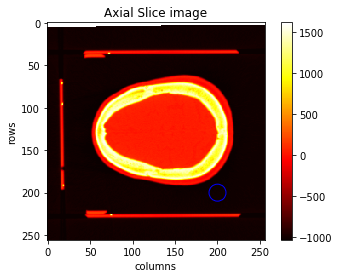

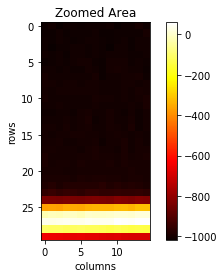

average is  -995.726162109375
NaN Removal on original data Complete


Text(0.5, 1.0, 'STACKED 140z')

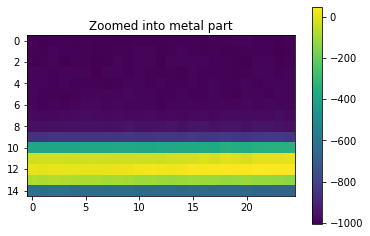

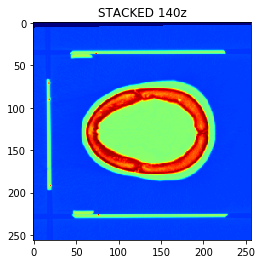

In [4]:
'''
################################################################################
Get stacked image with all of the NaNs removed and simple metal location found

################################################################################
'''

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

#input patient full file name from previous block


f = nii_input_file
img = nib.load(f)
data = img.get_fdata()

# Show original image
print('NII filename opened is ',f)


### DEBUG PLOT AND CIRCLES ONLY
fig, ax = plt.subplots()
snum = 134 #axial slicing
plt.imshow(data[:,:,snum],cmap='hot')
plt.xlabel('columns')
plt.ylabel('rows')
plt.title('Axial Slice image')
plt.colorbar()

circle1 = plt.Circle((200,200), 10,color='b', fill=False)
ax.set_aspect(1)
ax.add_artist(circle1)
plt.show()

#Zoomed area view
#

fig = plt.gcf()
ax = fig.gca()
plt.imshow(data[200:230,160:175,snum], cmap='hot')
plt.xlabel('columns')
plt.ylabel('rows')
plt.title('Zoomed Area')
plt.colorbar()
plt.show()


sum = np.sum(data[215:220,145:155,snum])
avg = np.average(data[215:220,145:155,140])
print('average is ', avg)


plt.figure()
plt.imshow(data[215:230,145:170,snum])
plt.colorbar()
plt.title('Zoomed into metal part')




# 
# Remove any NaN values before running over this data
#
sx,sy,sz = np.shape(data)

for ii in range(0,sz):
    #replace all NaN values with a default value
    new_data = replace_nan(data[:,:,ii], lowval=-1600)   
    if(ii ==0):
        stacked = new_data
    else:
        stacked = np.dstack([stacked,new_data])

print('NaN Removal on original data Complete')

plt.figure()
plt.imshow(stacked[:,:,140],cmap='jet')
plt.title('STACKED 140z')



In [5]:
'''
Get the metal points in the orthogonal direction now


if (run_all == 0):
    return

sx,sy,sz = np.shape(data)
metal_points90=[]
for ii in range(0,sy):
    #replace all NaN values with a default value
    new_data90 = replace_nan(data[:,ii,:], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc90 = find_metal_mass(section = new_data, metal_value = 3000, depth=4)
    metal_points90.append(loc)
    if(ii ==0):
        stacked90 = new_data90
    else:
        stacked90 = np.dstack([stacked90,new_data90])

print('Metal Points Orthogonal Complete')
'''

"\nGet the metal points in the orthogonal direction now\n\n\nif (run_all == 0):\n    return\n\nsx,sy,sz = np.shape(data)\nmetal_points90=[]\nfor ii in range(0,sy):\n    #replace all NaN values with a default value\n    new_data90 = replace_nan(data[:,ii,:], lowval=-1600)   \n    #stacked =np.dstack(stacked,new_data)\n    loc90 = find_metal_mass(section = new_data, metal_value = 3000, depth=4)\n    metal_points90.append(loc)\n    if(ii ==0):\n        stacked90 = new_data90\n    else:\n        stacked90 = np.dstack([stacked90,new_data90])\n\nprint('Metal Points Orthogonal Complete')\n"

In [6]:
#
# Create a binary NIFTI file the same size as our input data
#
numrows, numcols, depth = np.shape(stacked)


output_nii=create_binary_nifti(numrows,numcols, depth)



Created 3D cube with sizes r x c x d:  256 256 173


found proper  hull hull_subject_4.nii
found proper  hull hull_subject_5.nii
found proper  hull hull_subject_1.nii
found proper  hull hull_subject_3.nii
found proper  hull hull_subject_2.nii
{'subject_4': 'hull_subject_4.nii', 'subject_5': 'hull_subject_5.nii', 'subject_1': 'hull_subject_1.nii', 'subject_3': 'hull_subject_3.nii', 'subject_2': 'hull_subject_2.nii'}
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
found proper  hull hull.mat
{'subject_5': 'hull.mat', 'DBS_bG02': 'hull.mat', 'DBS_bG12': 'hull.mat', 'DBS_bG06': 'hull.mat', 'DBS_bG19': 'hull.mat', 'DBS_bG18': 'hull.mat', 'DBS_bG13': 'hull.mat', 'DBS_bG10': 'hull.mat', 'DBS_bG03': 'hull.mat', 'DBS_bG17': 'hull.mat', 'DBS_bG09_2': 'hull.mat'}
folder is  DBS_bG19
found a .mat HULL file:  hull.mat
read

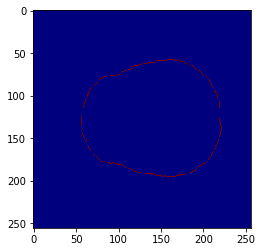

In [7]:
'''
Load Hull file containing cortical surface boundaries
'''

#print(dir_list)
#print(file_list)

#check for NII hull files first, otherwise check to see if a .mat version is
#available
hull_nii_files = get_nii_files(dir_list, file_list, "hull",".nii")
hull_mat_files = get_nii_files(dir_list,file_list, "hull", ".mat")

print('folder is ',folder_key[patient_id])




if (hull_nii_files.get(folder_key[patient_id],'NONE') != 'NONE'):
    hull_present = 1
    print(hull_nii_files[folder_key[patient_id]])
    a=folder_key[patient_id]
    hull_nii_files[a]
    print('folder key hull is ',hull_nii_files[folder_key[patient_id]])

    #patientid = 'subject_5'
    print(folder_key[patient_id])
    hull_file = os.path.join(main_directory ,
                            folder_key[patient_id],
                            hull_nii_files.get(folder_key[patient_id],'NONE'))
    hull_data = load_hull_file(hull_file)
    print(np.shape(hull_data))

elif(hull_mat_files.get(folder_key[patient_id],'NONE') != 'NONE'):
    print('found a .mat HULL file: ',hull_mat_files.get(folder_key[patient_id]))
    #
    #get the information needed to retrieve and format .mat hull data
    #
    [mrow,mcol, mz] = np.shape(data)
    [sx,sy,sz,hh]=img.get_sform()

    hull_path = os.path.join(main_directory, folder_key[patient_id])
    hull_file_name = hull_mat_files.get(folder_key[patient_id])
    hull_data = convert_mat_hull(hull_path,
                                 hull_file_name,
                                 mrow, mcol, mz,
                                 sx,sy,sz,hh)
    hull_present = 1

else:
    print('!!!!No HULL available for use!!!!!')
    hull_present = 0



COMPLETED OPEN SEQUENCE


'\n### Save eroded and dilated image to new nift, reuse old header\n#another_img = nib.Nifti1Image(new_data, img.affine, empty_header)\nerd_img = nib.Nifti1Image(erd_data, img.affine, img.header)\nmorph_file = os.path.join(path_dict[4,2],\'morphed_file.nii\')\nprint(\'morph file is \', morph_file)\nnib.save(erd_img, morph_file) #\'clipped_image.nii\')\n\nframe_dir = \'/content/gdrive/My Drive/ANIMATION_FIGS\'\nprint(frame_dir)\ncell_animate(frame_dir, "diff", diff_data,cmapin=\'jet\',cbar=1)\n\n\nhist,bins=np.histogram(erd_data[:,:,140],50)\nplt.hist(hist,bins)\nprint(np.shape(hist))\nprint(np.shape(bins))\n\n\n\n\nreturn\n\n\n#-------------------------------------------------------------------------------\n#Side-by-side plots\n#-------------------------------------------------------------------------------\n\nfig, axes = plt.subplots(nrows = 1,ncols = 4,figsize=(15, 15))\nim0 = axes[0].imshow(img_slice,cmap=\'jet\');\n\nim1 = axes[1].imshow(img_erosion[:,:],cmap=\'jet\')\nim2 = axes[2

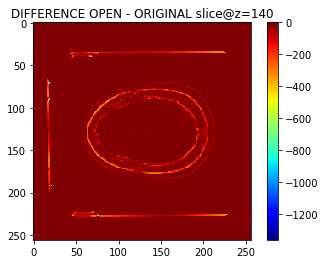

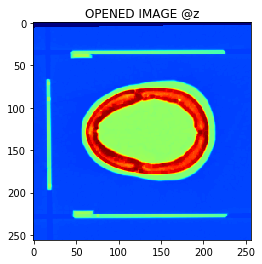

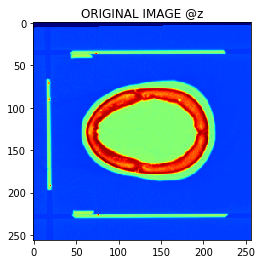

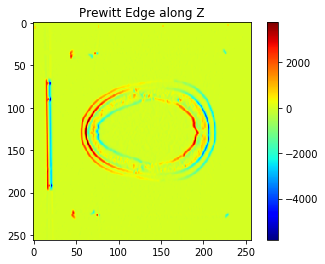

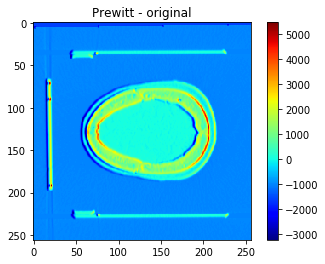

In [8]:
'''
--------------------------------------------------------------------------------
Apply a filter to the data before detecting metallic components
--------------------------------------------------------------------------------
'''

import numpy as np
from copy import copy, deepcopy  #to copy matrices



# Taking a matrix of size 3 as the kernel 
kernel = np.ones((3,3), np.float) 


# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
#img_slice = stacked[:,:,144]
#img_erosion = cv2.erode(img_slice, kernel, iterations=1) 
#img_erode_dilate = cv2.dilate(img_erosion, kernel, iterations=1)
#img_dilation = cv2.dilate(img_slice, kernel, iterations=1)


#-------------------------------------------------------------------------------
# Apply erosion and dilation
#-------------------------------------------------------------------------------
sx,sy,sz = np.shape(stacked)

pz = deepcopy(stacked)
erd_data = deepcopy(stacked)

# do an erosion followed by dilation. Try a prewitt edge detection filter for
#comparison
for ii in range(0,sz):
    erd_data[:,:,ii] =cv2.erode(stacked[:,:,ii],kernel, iterations=1)
    pz[:,:,ii] = ndimage.prewitt(stacked[:,:,ii])
    erd_data[:,:,ii] = cv2.dilate(erd_data[:,:,ii],kernel,iterations=1)

print('COMPLETED OPEN SEQUENCE')

#try a dilation in the orthogonal slice plane
#for ii in range(0,sy):
#    erd_data[:,ii,:] =cv2.dilate(stacked[:,ii,:],kernel, iterations=1)


#subtraction of original and opened image
diff_data = np.subtract(erd_data,stacked)
plt.figure()
plt.imshow(diff_data[:,:,140],cmap='jet')
plt.colorbar()
plt.title('DIFFERENCE OPEN - ORIGINAL slice@z=140')

plt.figure()
plt.imshow(erd_data[:,:,140],cmap='jet')
plt.title('OPENED IMAGE @z')

plt.figure()
plt.imshow(stacked[:,:,140],cmap='jet')
plt.title('ORIGINAL IMAGE @z')

plt.figure()
plt.imshow(pz[:,:,140],cmap='jet')
plt.colorbar()
plt.title('Prewitt Edge along Z')

plt.figure()
diffp = np.subtract(stacked,pz)
plt.imshow(diffp[:,:,140],cmap='jet')
plt.colorbar()
plt.title('Prewitt - original')


'''
#
# ERD METAL LOCATIONS
#

print('STARTING METAL LOCATION')
sx,sy,sz = np.shape(erd_data)
metal_points_erd=[]
mloc_dict={}
for ii in range(0,sz):
    slicenum = ii  #current slice
    onethirdslice = sz/3 #for a progress indicator

    if ((ii%50) == 0):
        print('ii now at ',ii)
    #replace all NaN values with a default value
    new_data_erd = replace_nan(erd_data[:,:,ii], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc_erd = find_metal_mass(section = new_data_erd,
                            metal_value = 2000, #2700
                            depth=1,
                            lower_val=0.95,   #0.9
                            upper_val = 1.50) #1.25
    #output of find_metal_mass is row, col, slice#


    #print('loc_erd shape is ',np.shape(loc_erd))
    if (len(loc_erd) ==0):
        #this is an empty list, due to not having any metallic signatures
        continue  #jump to the next slice
    else:
        #print('loc erd is ',loc_erd)
        for metal_pair in range(0,len(loc_erd)): #metal_pair in loc_erd:
            if (metal_pair > 1):
                #print('MANY LOC_ERD PAIRS')
                pass
            #print(type(metal_pair))
            #print(metal_pair)
            rownum = loc_erd[metal_pair][0]
            colnum = loc_erd[metal_pair][1]
            #assign the metal points for this slice to one key of the dictionary



            if slicenum not in mloc_dict.keys():
                mloc_dict[slicenum] =[]
                mloc_dict[slicenum].append([rownum,colnum])
            else:
                mloc_dict[slicenum].append([rownum, colnum])

print('Metal Points ERD Complete')




print('Applying metal markers to images')
apply_marker_to_metal(mloc_dict, erd_data, cmapin='bone',marker_color='r')

'''


'''
### Save eroded and dilated image to new nift, reuse old header
#another_img = nib.Nifti1Image(new_data, img.affine, empty_header)
erd_img = nib.Nifti1Image(erd_data, img.affine, img.header)
morph_file = os.path.join(path_dict[4,2],'morphed_file.nii')
print('morph file is ', morph_file)
nib.save(erd_img, morph_file) #'clipped_image.nii')

frame_dir = '/content/gdrive/My Drive/ANIMATION_FIGS'
print(frame_dir)
cell_animate(frame_dir, "diff", diff_data,cmapin='jet',cbar=1)


hist,bins=np.histogram(erd_data[:,:,140],50)
plt.hist(hist,bins)
print(np.shape(hist))
print(np.shape(bins))




return


#-------------------------------------------------------------------------------
#Side-by-side plots
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize=(15, 15))
im0 = axes[0].imshow(img_slice,cmap='jet');

im1 = axes[1].imshow(img_erosion[:,:],cmap='jet')
im2 = axes[2].imshow(img_dilation[:,:],cmap='jet')
im3 = axes[3].imshow(img_erode_dilate[:,:],cmap='jet')

#use fraction and pad to shrink colorbar to fit image
fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
fig.colorbar(im1,ax = axes[1],fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[2],fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[3],fraction=0.046, pad=0.04)

axes[0].set_title("Original")
axes[1].set_title("Erosion")
axes[2].set_title("Dilation")
axes[3].set_title("Erosion + Dilation")
fig.tight_layout()



# SAMPLE GAUSSIAN BLUR
new_image = cv2.GaussianBlur(stacked[:,:,140], (15,15),0)
plt.figure()
plt.imshow(new_image)


#-------------------------------------------------------------------------------
#Side-by-side plots
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize=(15, 15))
im0 = axes[0].imshow(erd_data[100,:,:],cmap='jet');

im1 = axes[1].imshow(erd_data[:,:,144],cmap='jet')
im2 = axes[2].imshow(erd_data[:,100,:],cmap='jet')


#use fraction and pad to shrink colorbar to fit image
fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
fig.colorbar(im1,ax = axes[1],fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[2],fraction=0.046, pad=0.04)


axes[0].set_title("ERD ROW 100")
axes[1].set_title("ERD Z   144")
axes[2].set_title("ERD COL 100")

fig.tight_layout()
'''


In [9]:
'''
################################################################################
Assign hull points from cube to dictionary. Dictionary points can be used to 
overlay onto images for a quick display

################################################################################
'''
hull_dict={} #init dictionary
centroid={}  #hold centroid vals

hx,hy,hz = np.shape(hull_data)

for hullslice in range(0,hz):
    hindex = np.argwhere(hull_data[:,:,hullslice] > 0.0)
    #print(np.shape(hindex))
    #print('len of hindex is ',len(hindex))

    if (len(hindex) == 0):
        #print('no hull found in slice ', hullslice)
        continue  #skip this one, no hull points found

    for ii in range(0,len(hindex)):
        hrow = hindex[ii][0]
        hcol = hindex[ii][1]
        #print('slice,row,col = ',hullslice, hrow, hcol)

        if hullslice not in hull_dict.keys():
            hull_dict[hullslice]=[]
            hull_dict[hullslice].append([hrow, hcol])

            centroid[hullslice]=[]
            centroid[hullslice].append([hrow,hcol])

                      
        else:
            hull_dict[hullslice].append([hrow, hcol]) 

            centroid[hullslice].append([hrow, hcol])

print('Hull points transfered to dictionary')

#
# Get centroid values for row and column
#



#print('Applying hull points to erd data')


apply_marker_to_metal(hull_dict, 
                    erd_data, 0,
                    cmapin='bone',
                    marker_color='r')

Output hidden; open in https://colab.research.google.com to view.

In [10]:
'''
################################################################################
# Expand the hull to fit skull a bit more. If no hull nifit was found, 
#skip this step for now
################################################################################
'''
hx,hy,hz = np.shape(stacked) #get size of newly created stack image
if (hull_present == 1):
    total_slices = hz #total number of slices in the data
    mx,my,dx,dy = get_center_hull(hz, hull_dict)

    #debug outputs
    print('dx type is ',type(dx))
    print('mx type is ', type(mx))
    
    for ii in mx:
        print(ii)

    print('All keys found')


    #
    # Scale up the input hull by sf %
    #
    sf= 1.20 #1.02
    expanded_hull_dict = scale_hull(hz, mx, my,centroid,sf)

    #print(mx,my)
    #print(len(expanded_hull_dict))



    apply_marker_to_metal(expanded_hull_dict, 
                        stacked,0,
                        cmapin='bone',
                        marker_color='g')

Output hidden; open in https://colab.research.google.com to view.

In [11]:
'''
CHECK THE CENTER POINT OF HULLS
'''
center_dict={}
for ii in mx.keys():
    center_dict[ii]=[]
    center_dict[ii].append([my[ii][0],mx[ii][0]])


apply_marker_to_metal(center_dict, 
                    stacked,0,
                    cmapin='bone',
                    marker_color='r')


Output hidden; open in https://colab.research.google.com to view.

STARTING METAL LOCATION
ii now at  0
loc_erd shape @ slice is  (0,) 0
loc_erd shape @ slice is  (0,) 1
loc_erd shape @ slice is  (0,) 2
loc_erd shape @ slice is  (0,) 3
loc_erd shape @ slice is  (0,) 4
loc_erd shape @ slice is  (0,) 5
loc_erd shape @ slice is  (0,) 6
loc_erd shape @ slice is  (0,) 7
loc_erd shape @ slice is  (0,) 8
loc_erd shape @ slice is  (0,) 9
loc_erd shape @ slice is  (0,) 10
loc_erd shape @ slice is  (0,) 11
loc_erd shape @ slice is  (0,) 12
loc_erd shape @ slice is  (0,) 13
loc_erd shape @ slice is  (0,) 14
loc_erd shape @ slice is  (0,) 15
loc_erd shape @ slice is  (0,) 16
loc_erd shape @ slice is  (0,) 17
loc_erd shape @ slice is  (0,) 18
loc_erd shape @ slice is  (0,) 19
loc_erd shape @ slice is  (0,) 20
loc_erd shape @ slice is  (0,) 21
loc_erd shape @ slice is  (0,) 22
loc_erd shape @ slice is  (0,) 23
loc_erd shape @ slice is  (0,) 24
loc_erd shape @ slice is  (0,) 25
loc_erd shape @ slice is  (0,) 26
loc_erd shape @ slice is  (0,) 27
loc_erd shape @ slice

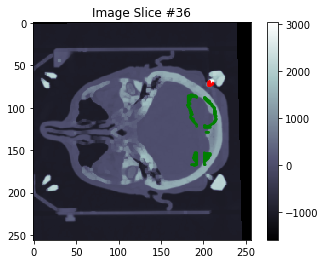

current slice is 37


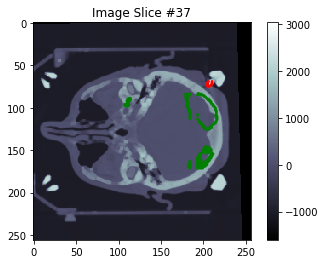

current slice is 38


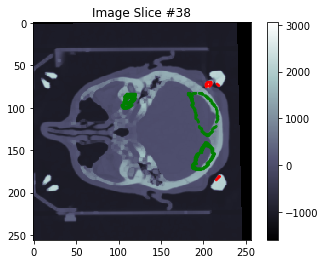

current slice is 39


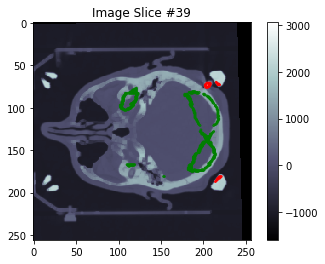

current slice is 40


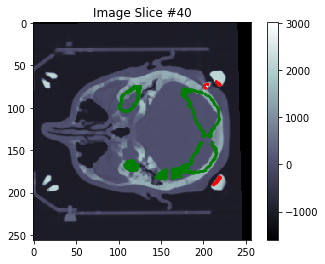

current slice is 41


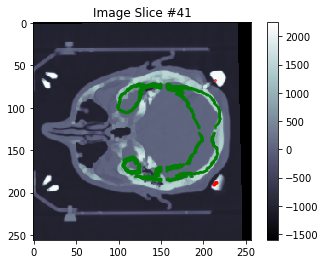

current slice is 42


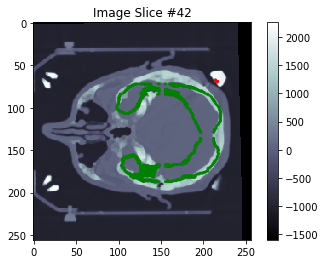

current slice is 43


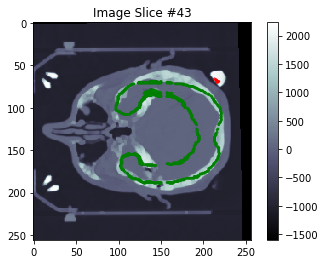

current slice is 44


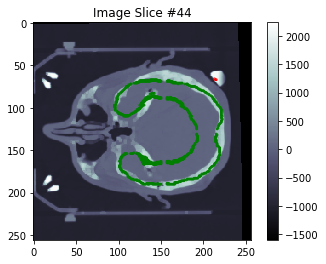

0

In [12]:
################################################################################
# ERD METAL LOCATIONS
################################################################################

print('STARTING METAL LOCATION')
sx,sy,sz = np.shape(erd_data)
metal_points_erd=[]
mloc_dict={}
for ii in range(0,sz):
    slicenum = ii  #current slice
    onethirdslice = sz/3 #for a progress indicator

    if ((ii%50) == 0):
        print('ii now at ',ii)
    #replace all NaN values with a default value
    new_data_erd = erd_data[:,:,ii] #replace_nan(erd_data[:,:,ii], lowval=-1600)   
    #print('nan replaced')
    #stacked =np.dstack(stacked,new_data)
    loc_erd = find_metal_mass(new_data_erd,
                            expanded_hull_dict,
                            slicenum,
                            dx,
                            dy,
                            mx,
                            my,
                            metal_value = 2000, 
                            depth=1,
                            lower_val=0.95,   
                            upper_val = 1.50)
    #output of find_metal_mass is row, col, slice#


    print('loc_erd shape @ slice is ',np.shape(loc_erd),ii)
    if (len(loc_erd) ==0):
        #this is an empty list, due to not having any metallic signatures
        continue  #jump to the next slice
    else:
        #print('loc erd is ',loc_erd)
        for metal_pair in range(0,len(loc_erd)): #metal_pair in loc_erd:
            if (metal_pair > 1):
                #print('MANY LOC_ERD PAIRS')
                pass
            #print(type(metal_pair))
            #print(metal_pair)
            rownum = loc_erd[metal_pair][0]
            colnum = loc_erd[metal_pair][1]
            #assign the metal points for this slice to one key of the dictionary



            if slicenum not in mloc_dict.keys():
                mloc_dict[slicenum] =[]
                mloc_dict[slicenum].append([rownum,colnum])
            else:
                mloc_dict[slicenum].append([rownum, colnum])

print('Metal Points ERD Complete')
print('#points to plot: ', len(mloc_dict.keys()))



print('Applying metal markers to base images')
apply_marker_to_metal(mloc_dict,
                      erd_data,
                      1,
                      'bone',    #cmap style
                      'r', #marker color
                      expanded_hull_dict,
                      'g')



In [0]:
'''
################################################################################
ASSIGN PIN POINTS TO NEW IMAGE
################################################################################
'''

#Find any pin points from above that live inside the hull

for key in mloc_dict.keys():
    points = mloc_dict[key]
    for ii in range(0,len(points)):
        output_nii[points[ii][0],points[ii][1],key] = 1


    #numrows, numcols, depth = np.shape(stacked)


#output_nii=create_binary_nifti(numrows,numcols, depth)

In [14]:
################################################################################
# Save to a NIFTI file
################################################################################


#nii_input_file = os.path.join(main_directory,
#                              folder_key[patient_id],nii_files[folder_key[patient_id]])
#print(nii_input_file)
#>>> base=os.path.basename('/root/dir/sub/file.ext')
#>>> base
#'file.ext'
#>>> os.path.splitext(base)
#('file', '.ext')
#>>> os.path.splitext(base)[0]


#output_nii
print(folder_key[patient_id])
print(nii_files[folder_key[patient_id]])
basename = os.path.basename(nii_files[folder_key[patient_id]])
print(basename)
rawname = os.path.splitext(basename)
print(rawname[0])
output_name = rawname[0] + '_PIN_TIPS.nii'

output_img = nib.Nifti1Image(output_nii, img.affine, img.header)
nifti_out_folder = '/content/gdrive/My Drive/BIOENG223A_FALL_2019/OUTPUT_NIFTI'

output_file = os.path.join(nifti_out_folder, output_name)  #'pin_output.nii')
nib.save(output_img, output_file) #save the new NIFTI file

return
### Save eroded and dilated image to new nift, reuse old header
#another_img = nib.Nifti1Image(new_data, img.affine, empty_header)
erd_img = nib.Nifti1Image(erd_data, img.affine, img.header)
morph_file = os.path.join(path_dict[4,2],'morphed_file.nii')
print('morph file is ', morph_file)
nib.save(erd_img, morph_file) #'clipped_image.nii')

frame_dir = '/content/gdrive/My Drive/ANIMATION_FIGS'
print(frame_dir)
cell_animate(frame_dir, "diff", diff_data,cmapin='jet',cbar=1)






DBS_bG19
coregistered_preopCT_Subject34.nii
coregistered_preopCT_Subject34.nii
coregistered_preopCT_Subject34


SyntaxError: ignored

In [0]:
'''
Overlay Hull onto OPENED data



#put hull data into dictionary for use with the apply markers function

#for every slice of hull, put the row,col of each point into a dictionary slice

hrow, hcol, hz = np.shape(hull_data)


plt.figure()
plt.imshow(hull_data[:,:,170],cmap='jet')
plt.colorbar()

hindex = np.argwhere(hull_data[:,:,170] > 0.0)
print(np.shape(hindex))
print('length of hindex is ', len(hindex))


hull_dict={} #init dictionary
centroid={}  #hold centroid vals


for hullslice in range(0,hz):
    hindex = np.argwhere(hull_data[:,:,hullslice] > 0.0)
    print(np.shape(hindex))
    print('len of hindex is ',len(hindex))

    if (len(hindex) == 0):
        print('no hull found in slice ', hullslice)
        continue  #skip this one, no hull points found

    for ii in range(0,len(hindex)):
        hrow = hindex[ii][0]
        hcol = hindex[ii][1]
        #print('slice,row,col = ',hullslice, hrow, hcol)

        if hullslice not in hull_dict.keys():
            hull_dict[hullslice]=[]
            hull_dict[hullslice].append([hrow, hcol])

            centroid[hullslice]=[]
            centroid[hullslice].append([hrow,hcol])

                      
        else:
            hull_dict[hullslice].append([hrow, hcol]) 

            centroid[hullslice].append([hrow, hcol])

print('Hull points transfered to dictionary')

#
# Get centroid values for row and column
#



print('Applying hull points to erd data')


apply_marker_to_metal(hull_dict, 
                    erd_data,0,
                    cmapin='bone',
                    marker_color='r')

In [0]:
'''
#
# Expand the hull to fit skull a bit more
#

total_slices = hz #total number of slices in the data
mx,my,dx,dy = get_center_hull(hz, hull_dict)

print(np.shape(mx))




sf=1.02
expanded_hull_dict = scale_hull(hz, mx.my,centroid,sf)

print(mx,my)
print(len(expanded_hull_dict))


apply_marker_to_metal(expanded_hull_dict, 
                    erd_data,0,
                    cmapin='bone',
                    marker_color='g')

In [0]:
################################################################################
#  IMAGES SOLEY FOR THE PAPER
#
################################################################################
return
paper_dir = '/content/gdrive/My Drive/PAPER_DATA'

plt.figure()
plt.imshow(erd_data[55:70,100:112,131],cmap='jet')
plt.colorbar()
plt.title('Sample Image after Open')
plt.xlabel('Column Voxels')
plt.ylabel('Row Voxels')
open_name = os.path.join(paper_dir, 'opened_file.png')
print('open name is ', open_name)
plt.savefig(open_name)

plt.figure()
plt.imshow(stacked[55:70,100:112,131],cmap='jet')
plt.colorbar()
plt.title('Original Image')
plt.xlabel('Column Voxels')
plt.ylabel('Row Voxels')
original_name = os.path.join(paper_dir, 'original_file.png')
plt.savefig(original_name)


plt.figure()
slice_name = os.path.join(paper_dir,'sliceview.png')
plt.plot(erd_data[220,:,140],'r-.')
plt.title('Row 220 slice through Z=140')
plt.xlabel('column')
plt.ylabel('voxel value (raw)')
plt.grid()
plt.savefig(slice_name)



return

print(np.shape(loc_erd))
print(loc_erd)
loc_erd[0][0]
for metal_pair in range(0,len(loc_erd)):
    print(metal_pair)

In [0]:
'''
sx = [[-1, 0 ,1],[-1 ,0,1],[-1 ,0 ,1]]
sy = [[-1,-1,-1],[0,0,0],[1,1,1]]
print(np.matrix(sx))
print(np.matrix(sy))

return

hist,bins=np.histogram(erd_data[:,:,140],15)
plt.hist(hist,bins)
plt.title('Histogram of Difference')
print(np.shape(hist))
print(np.shape(bins))
print(bins)
index1 = np.where(erd_data < 0)
index2 = np.where(erd_data >= 0)
print(np.shape(index))
temp = deepcopy(erd_data)
temp[index1[0][:],index1[1][:],index1[2][:]] = -5000
temp[index2[0][:],index2[1][:],index2[2][:]] = -4000
plt.figure()
plt.imshow(temp[:,:,140])
plt.colorbar()

sx = [[-1, 0 ,-1]]

In [0]:
'''
ADD MARKERS TO THE METALLIC POINTS FOUND EARLIER FOR REVIEW
'''
numslice=np.shape(metal_points)

print(numslice[0])
for ii in range(0,numslice[0]):
    fig, ax = plt.subplots()
    #plt.figure()
    plt.imshow(stacked[:,:,ii],cmap='gray',vmin=-1600, vmax=3300)
    plt.xlabel('X vox')
    plt.ylabel('Y vox')
    tname = 'Axial Slice #' + np.str(ii)
    plt.title(tname)
    plt.colorbar()
    #plt.show()

    metal_xy = metal_points[ii]
    for ii in metal_xy:
        r = ii[0]
        c = ii[1]
        #print('row, col is ', r, c)
        circle1 = plt.Circle((c,r), 3,color='r', fill=False)
        #ax.set_aspect(1)
        ax.add_patch(circle1)
        #ax.add_artist(circle1)
        #plt.hold(True)
    plt.show()



In [0]:
return 

'''
HISTOGRAM INFORMATION
'''
hist,bins=np.histogram(erd_data,25) #stacked[:,:,140],100)
plt.hist(hist,bins)
print(np.shape(hist))
print(np.shape(bins))
print(hist)
print(bins)



In [0]:
return  #made into a definition above
'''
MATLAB HULL FILE IMPORT AND TRANSFORM TO NII SPACE

'''
from numpy.linalg import inv


print(current_path)
test_path = '/content/gdrive/My Drive/BIOENG223A_FALL_2019/data/DBS_bG02'
hull_file_name = 'hull.mat'

hull_file = os.path.join(test_path, hull_file_name)

print(hull_file)

hull_data = sio.loadmat(hull_file)
print('data shape is',np.shape(hull_data))
print(type(hull_data))
print(hull_data.keys()) #'mask_indices' is the main key for this dict
mdata =hull_data['mask_indices']
print('mdata type ',type(mdata))
print('mdata shape',np.shape(mdata))
[hrows, hcols]= np.shape(mdata)  #get the size of the hull data
#mat = scipy.io.loadmat('file.mat')

#print(img)   #show the NII image header info available
[sx,sy,sz,hh]=img.get_sform()  #pull srow data, hh is the homologous row
print(sx)
print(sy)
print(sz)
print(hh)

#put the arrays together in one 2D stack. Column stack will put srow's in column
T=np.column_stack((sx,sy,sz,hh))
print(T)

#Multiply the data by the transform
#mdata needs a column of ones to make it n x 4 to multiply with a 4x4
Xcol = np.ones((hrows,1))
hdata = np.hstack((mdata,Xcol))

#new transformed data, should be the xzy image coordinates (needs rounding)
hull_form = np.dot(hdata,inv(T)) 

print(np.shape(hull_form))
hull_form = np.around(hull_form,0)

print(hull_form[100:110,:])

'''
From the NIFTI header,it will show these transform sets
srow_x          : [-4.7020197e-02 -2.6496649e-03  9.9777776e-01 -8.0972633e+01]
srow_y          : [-9.98893976e-01  1.24692917e-04 -4.69677448e-02  1.05718796e+02]
srow_z          : [ 0.0000000e+00 -9.9999642e-01 -2.6496649e-03  1.1021884e+02]

In MATLAB, they'll appear as this when loaded with the NIFTI read
T =

   -0.0470   -0.9989         0         0
   -0.0026    0.0001   -1.0000         0
    0.9978   -0.0470   -0.0026         0
  -80.9726  105.7188  110.2188    1.0000


The INVERSE of T can be used to go from .mat coordinates (CT) to image that 
allows the hull to exist in the plane with the NIFTI data
-- use matlab data  [data ones(size(data,1))] * inv(T) to spit out new xyz
coordinates. Round these new values and set a zeros matrix the size of your
image to get a 1 wherever there's an xyz point



'''


#data is the original NII image loaded in. We want to make another image of this
#same size to hold the hull points
print('size of expected data is ', np.shape(data))
[mrow,mcol, mz] = np.shape(data) 
new_hull = np.zeros((mrow,mcol, mz))

[number_h_rows,number_h_cols]= np.shape(hull_form)
for ii in range(0,number_h_rows):
    [xx,yy,zz,dump] = hull_form[ii,:].astype(int)
    #print('xx,yy,zz: ', xx,yy,zz)
    new_hull[xx,yy,zz]= 1


#sanity check, see if a hull shows up on a middle slice
plt.figure()
plt.imshow(new_hull[:,:,np.int(mz/2)],cmap='jet')




'''
The below can be used to plot the original .mat hull image data
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = mdata[:,0]
ydata = mdata[:,1]
zdata = mdata[:,2]

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
plt.xlabel('X')
plt.ylabel('Y')

plt.show()
plt.figure()
plt.imshow(mdata[:,0],mdata[:,1])
'''

In [0]:
'''
Testing 3d metal extraction
'''


mloc_dict={}
print(np.shape(stacked))
volume_data = img
dimensions = np.shape(stacked) #stacked has already had nan removal done

metal_value = 3000 #contrast value for typical metal

cols = dimensions[0]
rows = dimensions[1]
slices = dimensions[2]

#store xy points that have metal

for slicenum in range(0,slices):
    #if slicenum not in mloc_dict.keys():
    #    mloc_dict[slicenum] = []

    for rownum in range(0,rows):
        for colnum in range(0,cols):
            pixel_value = stacked[rownum, colnum,slicenum]
            if (pixel_value >= metal_value):
                #print('Metal found in slice/x/y', slicenum, rownum, colnum)
                #mlocations.append([rownum, colnum, slicenum])
                
                if slicenum not in mloc_dict.keys(): #first time seeing this
                    mloc_dict[slicenum]=[]
                    mloc_dict[slicenum].append([rownum, colnum, slicenum])

                    print('new dict @key @pixel value @row,col',slicenum,pixel_value,rownum,colnum)
                else:
                    #mloc_dict[slicenum] = [mloc_dict[slicenum],[rownum, colnum, slicenum]]
                    mloc_dict[slicenum].append([rownum, colnum, slicenum])
                    #print('adding value to dict')
                    
key = mloc_dict.get('keys')
print('key is ',key)
print('length of dict',len(mloc_dict))
#[*mloc_dict] same as iterating through the dictionary to get key values



In [0]:
'''
ADD CIRCLE TO METALLIC SPOTS


print(mloc_dict.keys())  #debug to check which slices

## Test out a point
print(len(mloc_dict[9]))
print(type(mloc_dict[9]))
print(mloc_dict[9])
mloc_dict[9][0]


for current_slice_key in mloc_dict:
    print('current slice is',current_slice_key)
    fig,ax = plt.subplots()
    plt.imshow(stacked[:,:,current_slice_key],cmap='bone')

    for entry in mloc_dict[current_slice_key]:
        #print('slice, entry', current_slice_key,entry)
        row = entry[0]
        col = entry[1]

        circle1 = plt.Circle((col,row), 3,color='r', fill=False)
        ax.add_patch(circle1)
    plt.colorbar()
    plt.title(current_slice_key)
    plt.show()

'''

In [0]:
'''
ANIMATION OF A STACK OF SLICES
-- writes to the Google storage only
'''
animate_on = 0
if (animate_on == 1):
    frame_dir = '/content/gdrive/My Drive/ANIMATION_FIGS'
    #frame_dir = '/home/kgonzalez/BE223A_2019/FRAMES'
    print(frame_dir)
    #plt.savefig('/home/kgonzalez/TEMP/test.png')
    #animate_image(frame_dir, "figure", stacked)
    cell_animate(frame_dir, "figure", stacked)

In [0]:
'''
Pull DBS locations


for x in path_dict:
    #print(x,path_dict[x])
    continue
for x in file_dict:
    print(x, file_dict[x])
    continue
f = os.path.join(path_dict[4,2],file_dict[4,1])
post_img = nib.load(f)
post_data = post_img.get_fdata()

# Show original image
print('filename is ',f)


sx,sy,sz = np.shape(post_data)
metal_points=[]
for ii in range(0,sz):
    new_data = replace_nan(post_data[:,:,ii], lowval=-1600)   
    #stacked =np.dstack(stacked,new_data)
    loc = find_metal_mass(section = new_data, metal_value = 2800, depth=2)
    metal_points.append(loc)
    if(ii ==0):
        stacked_post = new_data
    else:
        stacked_post = np.dstack([stacked_post,new_data])

print('Metal Points Complete')
'''

'''
Replace NAN
'''
#new_data = replace_nan(data[:,:,snum], lowval=-1600)


In [0]:
'''
Show Post-Op stacked images after metal finding

print(metal_points)

numslice=np.shape(metal_points)

print(numslice[0])
for ii in range(0,numslice[0]):
    fig, ax = plt.subplots()
    #plt.figure()
    plt.imshow(stacked_post[:,:,ii],cmap='gray',vmin=-1600, vmax=3300)
    plt.xlabel('X vox')
    plt.ylabel('Y vox')
    tname = 'Post-Op Axial Slice #' + np.str(ii)
    plt.title(tname)
    plt.colorbar()
    #plt.show()

    metal_xy = metal_points[ii]
    for ii in metal_xy:
        r = ii[0]
        c = ii[1]
        #print('row, col is ', r, c)
        circle1 = plt.Circle((c,r), 3,color='r', fill=False)
        #ax.set_aspect(1)
        ax.add_patch(circle1)
        #ax.add_artist(circle1)
        #plt.hold(True)
    plt.show()
'''

In [0]:
'''
TRANSFORMATION INFO

#cm = img.coordmap
#print(cm)

strans=img.get_sform()

t=[]
for ii in strans:
    print('transform row is',ii)
    t.append(ii)
print(type(strans))
xrow = strans[0]
yrow = strans[1];
zrow = strans[2];
hrow = strans[3];

tmatrix = [xrow,yrow,zrow,hrow]
print(np.shape(tmatrix))
print(np.shape(xrow))

for row in range(0,256):
    for col in range(0,256):
        vec = [row,col,1,1]
        xnew,ynew,znew,hnew=  np.matmul(tmatrix,vec)
        #print('row,col --> xn,yn,zn,hn', row, col, xnew,ynew,znew,hnew)

print(t[0])
x = t[0]


n1_header = img.header
print(n1_header)


'''

In [0]:

'''
Rotation of CT images to match the Flouro images

#pick a slice, 140 for postOp 5 works well
#f = os.path.join(path_dict[0,0],file_dict[0,1])
ct_img = img #nib.load(f)
data_ct = ct_img.get_fdata()

af=img.affine
print(af)
affax=nib.aff2axcodes(img.affine)
print(affax)
#PIR is Ant to Post, Superior to inferior, Left to Right
canonical_img = nib.as_closest_canonical(img)
caff = canonical_img.affine
print('caff is ',caff)

new_affax=nib.aff2axcodes(canonical_img.affine)
print('New Affine Ordering: ',new_affax)
print(type(caff))
xs = []
ys = []
val = []


for row in range(0,256):
    for col in range(0,256):
        xyz = np.array([[row, col ,1, 1]])
        #print('shape xyz ',np.shape(xyz))
        xyzT=xyz.transpose()
        #print('shape xyz'' ',np.shape(xyzT))
        #print('shape caff is ',np.shape(caff))
     
        newx,newy,newz,H = np.dot(caff,xyzT) #matrix(caff,xyzT)
        xs.append(newx)
        ys.append(newy)

sdata = data_ct[:,:,140]







# Show original image
#print('filename is ',f)

#dir(img)

r,c,z=data_ct.shape
print('row, col, slice = ',r,c,z)
#choose slice number here
snum = 140 #slice number

data_ct_nonan =replace_nan(data_ct[:,:,snum], lowval=-1600)

maxc = np.max(data_ct_nonan[:,:])
minc = np.min(data_ct_nonan[:,:])


print('max, min value in slice is ', maxc, minc)
plt.imshow(data_ct_nonan[:,:],cmap='jet',vmin=-1600, vmax = 3300)
plt.title('Original UnRotated Slice Image')
plt.colorbar()

#rotate image with scipy, don't alter rotated image 
rot_angle = -60 #degrees CCW
rot_img = ndimage.rotate(data_ct[:,:,snum],-60, reshape=False)
plt.figure()
plt.imshow(rot_img,cmap = 'jet',vmin=-1200, vmax = 3000)
plt.colorbar()

f = os.path.join(path_dict[4,2],'fluoro_subject_5.tif')
tiff_file = f
I = plt.imread(tiff_file)
plt.figure()
plt.imshow(I)
plt.title('Example Flouroscope Surgery Image')
plt.xlabel('Column Position')
plt.ylabel('Row Position')


'''

In [0]:
'''
Get the slices for the dataset that have metallic signatures (highest values)


a=np.isnan(data)
lowval = -1600
new_data = data
new_data[np.isnan(new_data)]=-1600

plt.imshow(new_data[:,:,130],cmap = 'bone')
plt.colorbar()

slice = new_data[:,:,130]

print("values > metal are ",slice[slice> metal_value])
print("indices to high vals are ",np.nonzero(slice> metal_value))

metal_slices = []
num_slices = np.shape(data)[2]
for ii in range(0,num_slices):
    slice = new_data[:,:,ii]
    #print("slice number ",ii)
    values = slice[slice> metal_value]
    
    if (len(values) > 0):
        #print("values > metal are ",slice[slice> metal_value])
        #print("indices to high vals are ",np.nonzero(slice> metal_value))
        plt.figure()
        plt.imshow(slice[:,:], cmap='hot')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(ii)
        plt.colorbar()
        metal_slices.append(ii) #add this slice number to the metal list
        
    else:
        #print('length of values is ', len(values))
        continue
'''

In [0]:
'''
import time
from IPython import display

dsize = data.shape
degree = 5
for xx in range(40,50): #dsize[2]):
    #fig = plt.figure()
    plt.clf()
    #plt.imshow(data[:,:,xx],cmap='bone')
    #plt.colorbar()
    #plt.show()


    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #time.sleep(0.1)
    tr = transforms.Affine2D().rotate_deg(degree)
    plt.imshow(data[:,:,xx],transform = tr)
    #ax.imshow(img, transform=tr)
    #fig.canvas.draw()
#plt.imshow(data[:,:,150])
#plt.colorbar()

'''


